To start with, run the following commands to ensure you have all the correct packages installed

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cmcrameri import cm
import ScientificColourMaps8 as SCM8
from scipy.stats import norm
from scipy.interpolate import interp1d
import math
import random
import warnings
warnings.filterwarnings('ignore')

We are going to use some in-built functions in the field 'Ti_dynamo_code.py' which can be edited using something like Visual Studio Code if you wish to play around with the nuts and bolts

In [14]:
from Ti_dynamo_code import *

# Generating Ti-rich diapirs

First, we're going to produce a distribution of Ti-diapirs, ranging in size from 0--40 km. We can alter the degree of bias towards large or small diapirs by editing $D_{size}$, and the number of diapirs by editing $D_{max}$ where `Diapir`($D_{max}$,$D_{size}$). The smaller the value of $D_{size}$, the more uniform the distribution of diapirs.  The larger the value of $D_{max}$, the higher the number of diapirs that can be released simultaneously.

In [16]:
d = Diapir (1000,10)

We can now investigate the distribution of the diapirs we're produced by using the function `diapir_size()`

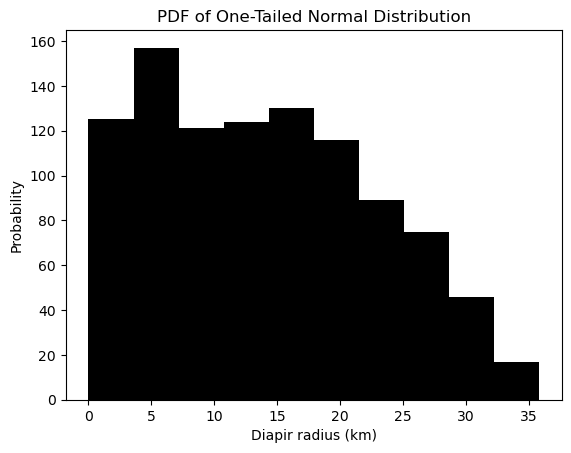

In [15]:
x, cdf = d.diapir_size()

# Randomly sample from the distribution
num_samples = 1000
x_samples = np.random.uniform(0, 1, num_samples)

interp_cdf = interp1d(cdf, x)

sampled_diapir_size = interp_cdf(x_samples)

# Plot the scaled reversed PDF
plt.hist(sampled_diapir_size, color='black')
plt.xlabel('Diapir radius (km)')
plt.ylabel('Probability')
plt.title('PDF of One-Tailed Normal Distribution')

# Show the plot
plt.show()

Now we've created our distribution of diapirs, we can generate a random population of diapirs that could be dropped in a single timesttep using `diapir_generate()`.  We can play around with how many diapirs are released simultaneously be changing the value of $D_{max}$. <br>

**N.B., you might have to try running this a few times to get a non-zero result!**

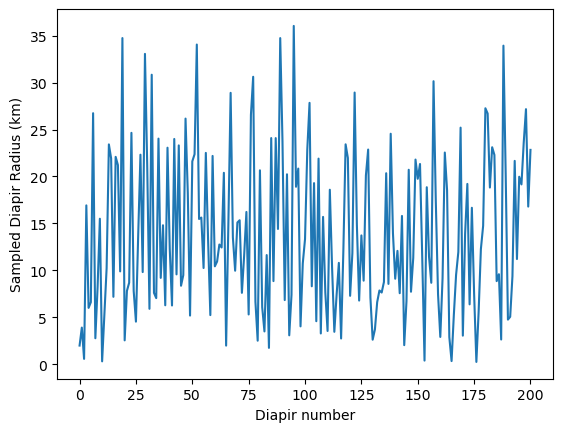

In [19]:
sampled_diapir_radius,_, num_samples = d.diapir_generate()

plt.plot(sampled_diapir_radius)
plt.xlabel('Diapir number')
plt.ylabel('Sampled Diapir Radius (km)')

plt.show()

Next, we can calculate some dimensions that represent the total amount of Ti-rich material dropped in a single time step using `diapir_dimensions()`.  We can calculate the total volume of material, the equivalent radius assuming the total volume is perfectly spherical, and the thickness of this layer above the core-mantle boundary if we assume it spreads out perfectly homogeneously over the surface of the core. 

In [22]:
d.diapir_dimensions()

print("Total diapir volume", d.sum_diapir_volume, "km3")
print("Spherical radius of total diapir volume", d.total_diapir_radius, "km")
print("Height of Ti-rich cumulates at CMB", d.sum_height, "km")


Total diapir volume 5025736.905750522 km3
Spherical radius of total diapir volume 106.26013911917684 km
Height of Ti-rich cumulates at CMB 3.234790197082418 km


# Melting Ti-rich diapirs

Melting time is considered in three ways: <br>
Scenario 1 - as a function of the thickness of a layer desposited on top of the CMB; <br>
Scenario 2 - proportional to the volume of the largest diapir dropped in a single time step; and <br>
Scenario 3 - as an entirely independent variable. <br>

Melting times are given in kyrs. <br>

`melting_time` = (`diapir`, `method`, $t_{Off}$, $t_{On}$=None, $c$=None, `fixed`=False) <br>
`diapir` in this case is $d$ that we generated above. <br>
`method` is "height" for scenario 1, "volume" for scenario 2, and "independent for scenario 3. <br>
$t_{Off}$ is the maximum duration of off periods in ka, and can be varied.
$t_{Off}$ is the maximum duration of melting perods, and should only be used when `method` = "independent" <br>
$c$ is the melting constant, can be varied, and should be used when `method` = "height" or "volume" <br>
`fixed` creates reproducible runs by consistently choosing the same random variables for each run. 

**Scenario 1:**  We assume this layer is placed straight onto the core and don't consider existing layers.  The constant of proportionality, $c$ between melting time and diapir volume is arbitrary and can be varied.

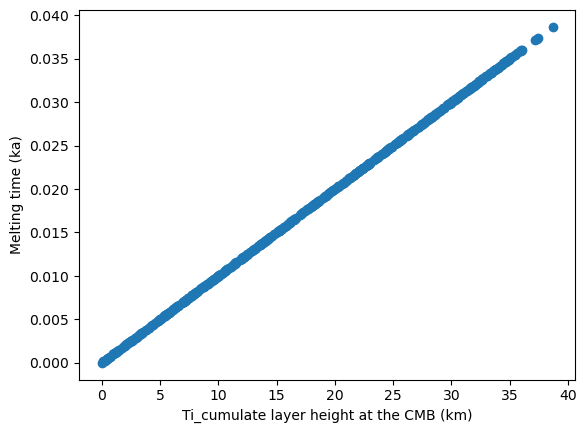

In [31]:
t_melt_list = []
height_list = []

#variables that can be altered
Dmax = 1000
Dsize = 1
tOff = 10
c = 0.001

#generate 1000 samples to see how CMB height influences melting time
for x in range(1000):
    d = Diapir(Dmax,Dsize)
    _ ,_ , num_samples = d.diapir_generate()
    _ ,_ , height = d.diapir_dimensions()
    # Check if any diapirs were generated
    if num_samples > 0:
        t_melt = melting_time(d, 'height', tOff, constant=c)
        t_melt_list.append(t_melt)
        height_list.append(height)
        
t_melt_array = np.array(t_melt_list)
height_array = np.array(height_list)

plt.scatter(height_array, t_melt_array)
plt.xlabel('Ti_cumulate layer height at the CMB (km)')
plt.ylabel('Melting time (ka)')

plt.show()

**Scenario 2:** The constant of proportionality, $c$ between melting time and diapir volume is arbitrary and can be varied.

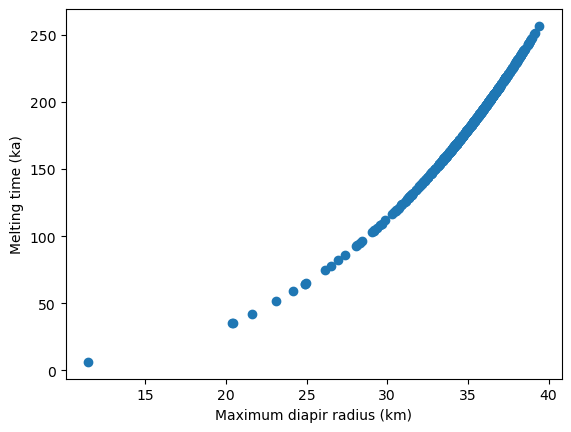

In [32]:
t_melt_list = []
max_diapir_list = []

#variables that can be altered
Dmax = 1000
Dsize = 40
tOff = 10
c = 0.001

#generate 1000 samples to see how CMB height influences melting time
for x in range(1000):
    d = Diapir(Dmax, Dsize)
    _ , max_d, num_samples = d.diapir_generate()
    # Check if any diapirs were generated
    if num_samples > 0:
        t_melt = melting_time(d, 'volume', tOff, constant=c)
        t_melt_list.append(t_melt)
        max_diapir_list.append(max_d)
    
t_melt_array = np.array(t_melt_list)
max_diapir_array = np.array(max_diapir_list)


plt.scatter(max_diapir_array, t_melt_array)
plt.xlabel('Maximum diapir radius (km)')
plt.ylabel('Melting time (ka)')

plt.show()

**Scenario 3:** In this case, we can just arbitrarily choose the largest melting time value $t_{on}$ (in ka) which randomly samples melting times below this limit.

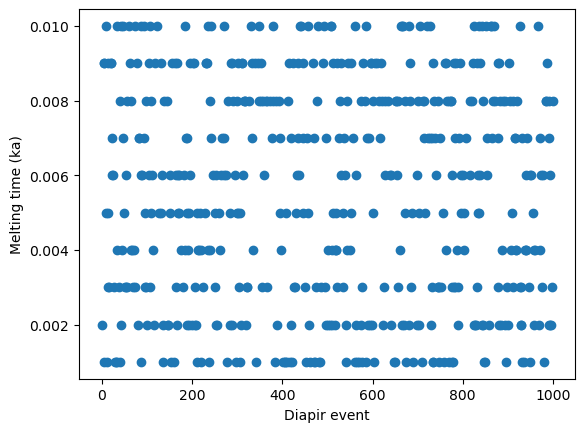

In [33]:
t_melt_list = []
x_list = []

#variables that can be altered
Dmax = 1000
Dsize = 10
tOff = 10
c = 0.001

#generate 1000 samples to see how CMB height influences melting time
for x in range(1000):
    d = Diapir(Dmax, Dsize)
    _ ,_ , num_samples = d.diapir_generate()
    # Check if any diapirs were generated
    if num_samples > 0:
        t_melt = melting_time(d, 'independent', tOff, tOn=c)
        t_melt_list.append(t_melt)
        x_list.append(x)
    
t_melt_array = np.array(t_melt_list)
x_array = np.array(x_list)

plt.scatter(x_array, t_melt_array,)
plt.xlabel('Diapir event')
plt.ylabel('Melting time (ka)')

plt.show()

# Generating a magnetic field

Regardless of which of the three scenarios is used above to calculate melting time, $t_{melt}$, the relationship between CMB heat flux, the surface magnetic field and the melting time is considered in the same way using `FieldCalc`($t_{melt}$, $d$), where $d$ is the generated distribution of diapirs and $t_{melt}$ is the calculated melting time. <br>

The heat flux accross the CMB can be calculated using the function `heat_flux_calc()`<br>

The resulting surface magnetic field can be calculated using the function `field_calc()`.

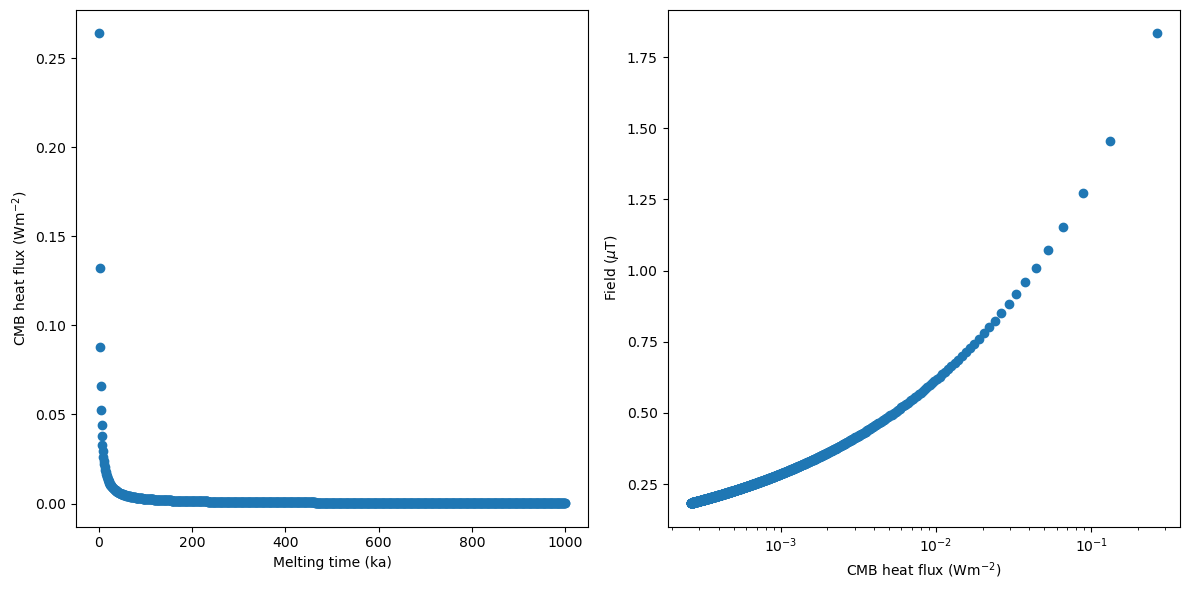

In [48]:
#Create empty lists to store values
flux_list = []
field_list = []
t_melt_list = []

#variables that can be altered
Dmax = 10
Dsize = 1

#Generate some diapirs and calculate their size
d = Diapir(Dmax, Dsize)
d.diapir_dimensions()

for x in range (1000):
    #Melt the diapirs
    t_melt = x

    #Calculate heat flux and field strength
    f = FieldCalc(t_melt, d)
    Q_cmb = f.heat_flux_calc()
    B_microT = f.field_calc()
    
    #Append values to lists
    field_list.append(B_microT)
    flux_list.append(Q_cmb)
    t_melt_list.append(x)

flux_array = np.array(flux_list)
t_melt_array = np.array(t_melt_list)
field_array = np.array(field_list)

# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First scatter plot: Melting time vs CMB heat flux
axes[0].scatter(t_melt_array, flux_array)
axes[0].set_xlabel('Melting time (ka)')
axes[0].set_ylabel('CMB heat flux (Wm$^{-2}$)')

# Second scatter plot: CMB heat flux vs Field
axes[1].scatter(flux_array, field_array)
axes[1].set_xlabel('CMB heat flux (Wm$^{-2}$)')
axes[1].set_ylabel('Field ($\mu$T)')
axes[1].set_xscale('log')  # Set the x-axis to a logarithmic scale

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


# Simulating an intermittent dynamo history

Now, we can run all of these steps together to produce plots of how intensity varies as a function of time, as the Ti_cumulates are building up to a maximum value of 200 km at the CMB, with a total volume of $520 \times 10^6$ km$^3$.<br>

To generate a full dynamo history, we can use `DynamoGenerate`($D_{max}$, $D_{size}$, $t_{Off}$, `method`, $c$ = None, $t_{On}$ = None, `fixed` = False) <br>
$D_{max}$ is the maximum number of diapirs that can be released in a single time step <br>
$D_{size}$ controls the distribution of diapirs (1 = uniform distribution, 40 = biased to small diapirs) <br>
`method` is "height" for scenario 1, "volume" for scenario 2, and "independent for scenario 3. <br>
$t_{Off}$ is the maximum duration of off periods in ka.
$t_{Off}$ is the maximum duration of melting perods, and should only be used when `method` = "independent" <br>
$c$ is the melting constant and should be used when `method` = "height" or "volume" <br>
`fixed` creates reproducible runs by consistently choosing the same random variables for each run. 

**Melting Scenario 1:**

In [63]:
#variables to be adjusted
Dmax = 1000
Dsize = 10
tOff = 10000
method = 'height'
c = 0.001

#generate a dynamo history
dynamo = DynamoGenerate(Dmax,Dsize,tOff,method, constant = c)

We can then plot the dynamo history to see when a magnetic field is generated, how strong the magnetic field was, and how quickly we are using up Ti-rich cumulate in terms of both their volume at the CMB (blue) and their height above the CMB (red) using `plot_int_vs_time()`

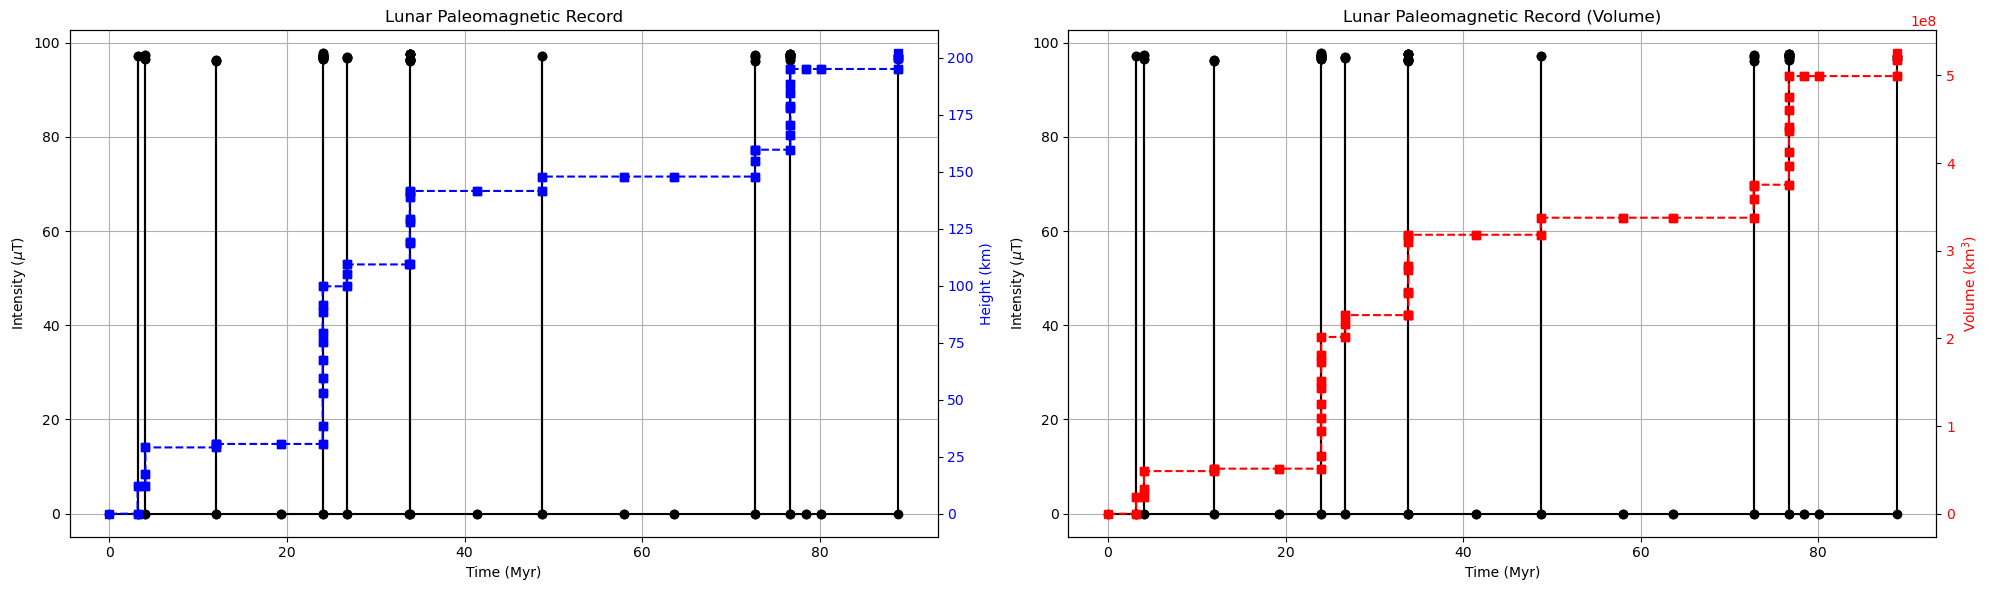

In [54]:
dynamo.plot_int_vs_time()

**Melting Scenario 2:**

In [62]:
#variables to be adjusted
Dmax = 1000
Dsize = 10
tOff = 10000
method = 'volume'
c = 0.001

#generate a dynamo history
dynamo = DynamoGenerate(Dmax,Dsize,tOff,method, constant = c)

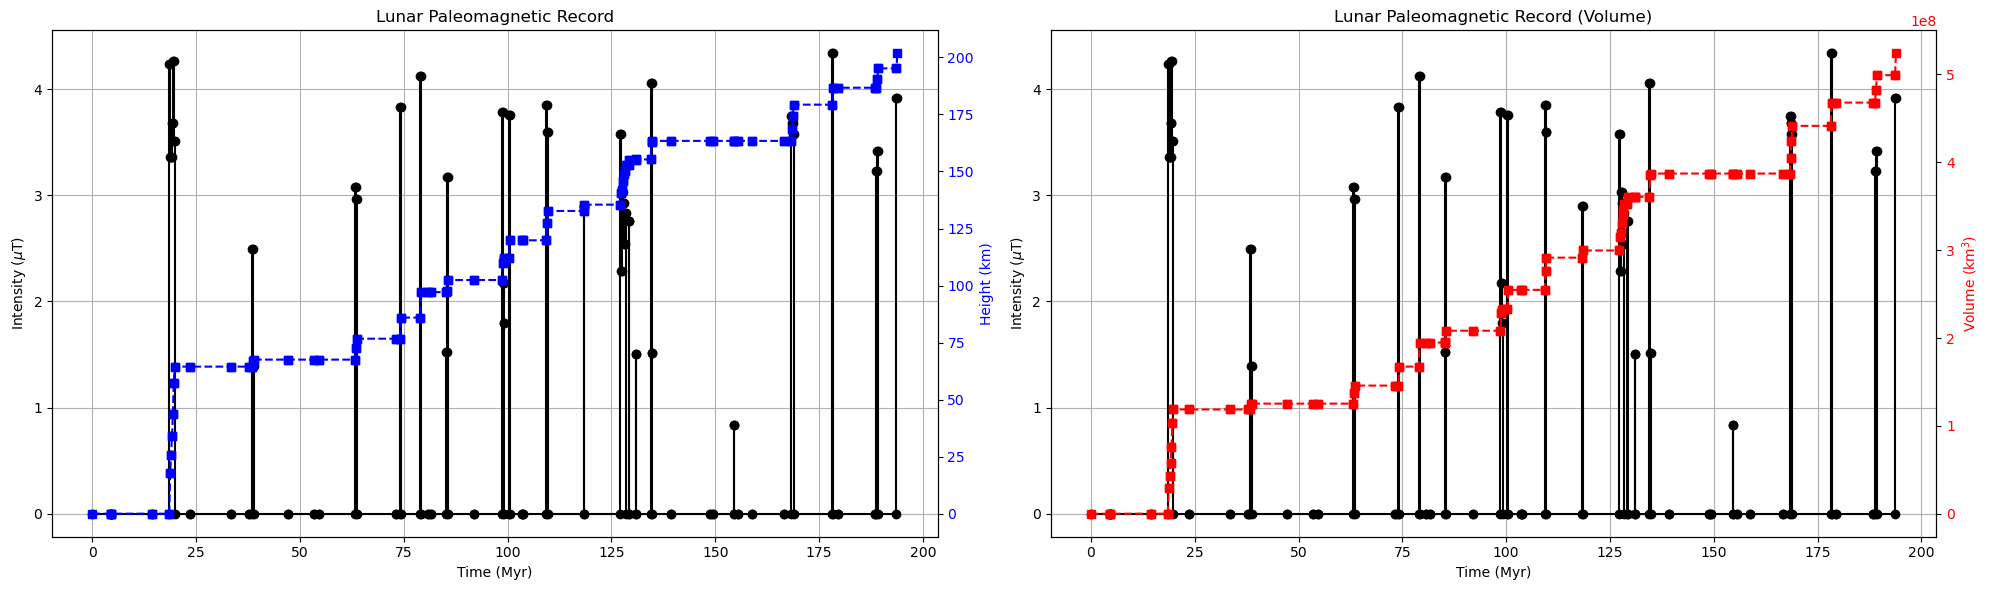

In [56]:
dynamo.plot_int_vs_time()

**Melting Scenario 3:**

In [61]:
#variables to be adjusted
Dmax = 1000
Dsize = 10
tOff = 10000
method = 'independent'
c = 0.001

#generate a dynamo history
dynamo = DynamoGenerate(Dmax,Dsize,tOff,method, tOn = c)

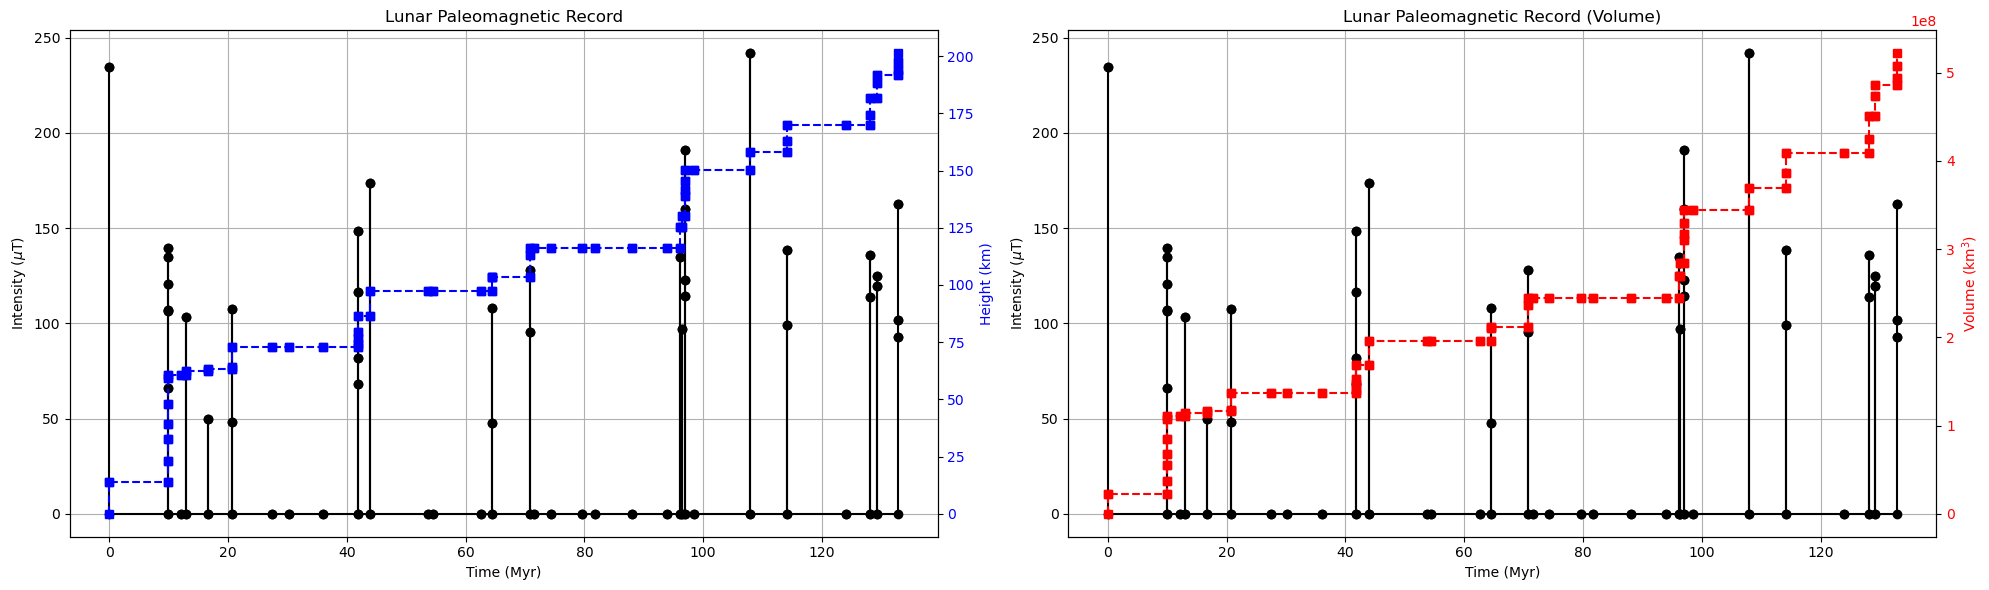

In [60]:
dynamo.plot_int_vs_time()

# Dynamo history properties

For a generated dynamo history, we can calculate a series of quantitative properties to assess the behaviour using `dynamo_history`. This returns: <br>
- the percentage of time the intermittent dynamo was generating a field <br>
- the total duration of the intermitten dynamo in ka <br>
- the average field strength of the generated field in microtesla <br>
- the maximum field strength of the generated field in microtesla <br>
- the minimum field strength of the generated field in microtesla <br>
- the average melting time of diapirs in ka <br>
- the average duration of periods of cessation between active field generation in ka <br>
- the average volume of Ti-rich material released in a single time step. 

In [64]:
#variables to be adjusted
Dmax = 1000
Dsize = 10
tOff = 10000
method = 'independent'
c = 0.001

#generate a dynamo history
dynamo = DynamoGenerate(Dmax,Dsize,tOff,method, tOn = c)

In [65]:
dynamo.dynamo_history()

(8.677800761471917e-05,
 195902.16999999998,
 123.88702168436032,
 230.6884436778666,
 43.1970480763441,
 0.004594594594594595,
 4897.55,
 6761159.9970906265)

# A parameter sweep of dynamo properties

We can sweep through a range of values for each parameter $D_{max}$, $D_{size}$, $t{Off}$, $c$ or $t_{On}$ (depending on the chosen method) and calculate the properties of the resulting dynamo history for each combination using `loop_dynamo()`.  The combination of parameters corresponding to each dynamo history is saved using `loop_dynamo_parameters()`.

In [67]:
#For melting scenario 3
method = 'independent'
Dmax_values = np.logspace(1,4,3)
tOff_values = np.logspace(2,4,3)
tOn_values = np.logspace(-4,1,3)
Dsize_values = np.linspace(1,40,3)

properties_list = dynamo.loop_dynamo(
    method,
    Dmax_values, 
    tOff_values, 
    Dsize_values,
    tOn_values = tOn_values,
    save_output = False,
    outfile_name = "test_loop_output.csv"
)

parameters_list = dynamo.loop_dynamo_parameters(
    method,
    Dmax_values, 
    tOff_values, 
    Dsize_values,
    tOn_values = tOn_values,
    save_output = False,
    outfile_name = "test_loop_parameters.csv"
)

We can then convert the output data to a dataframe in order to do more advanced analysis and plotting using `dynamo_loop_properties_dataframe()`.

In [72]:
dynamo.dynamo_loop_properties_dataframe()
dynamo.properties_df

,percent_on,total_on,av_B,max_B,min_B,av_melt,tOff,av_vol
0,0.000905,101807.921800,69.505130,191.609984,0.737311,0.000544,50.424468,1.401136e+05
1,0.291587,104741.412776,9.969707,25.206525,0.137429,0.172940,49.684110,1.344422e+05
2,48.307579,187217.000000,1.513062,4.060905,0.000127,53.673591,49.175305,1.424459e+05
3,0.000926,343357.181200,43.927419,136.498767,0.128112,0.000553,48.778804,4.065546e+04
4,0.282246,354941.809563,6.467266,20.563046,0.016302,0.175448,49.913975,4.062953e+04
...,...,...,...,...,...,...,...,...
76,0.002654,41702.106797,64.245948,103.391586,29.404634,0.158114,5212.625000,3.487839e+07
77,1.197628,51769.000000,8.895894,18.281951,3.875465,62.000000,7307.000000,3.169183e+07
78,0.000008,50132.004200,441.644359,644.457359,118.254303,0.000467,5013.200000,3.088971e+07
79,0.003708,30700.138420,66.051845,95.238314,35.802431,0.142302,3411.000000,3.110384e+07


An example of the kind of plot we can generate for a parameter sweep of dynamo histories is shown below

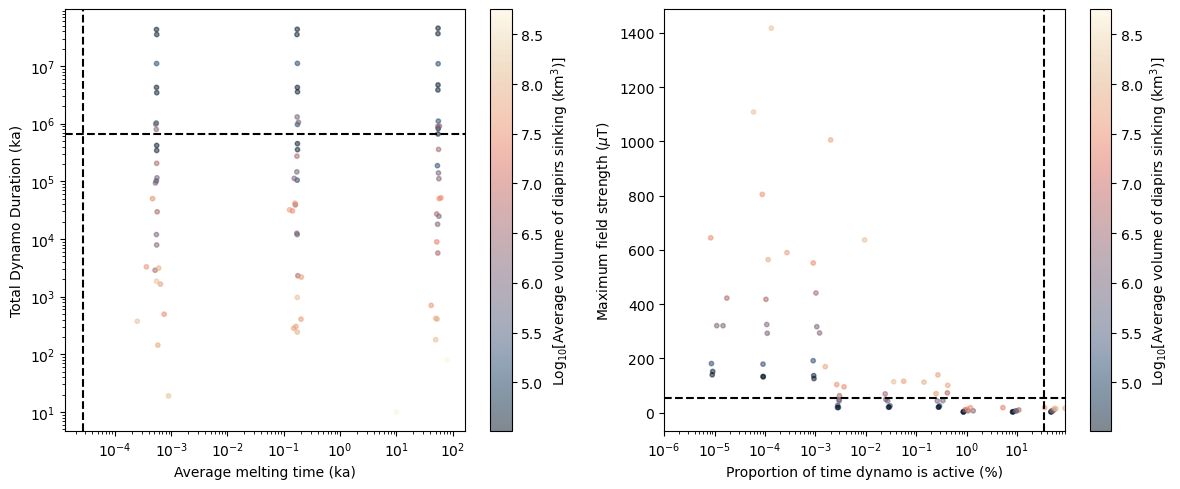

In [75]:
# Create the first scatter plot with a color bar and axis limits
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot radius vs time off as a function of total dynamo duration
scatter1 = ax1.scatter(dynamo.properties_df['av_melt'], 
                       dynamo.properties_df['total_on'], 
                       s=10, 
                       c=np.log10(dynamo.properties_df['av_vol']), 
                       cmap=SCM8.lipari, 
                       alpha=0.5
                      )
ax1.axhline(y=0.664e6, color='black', linestyle='--')
ax1.axvline(x=2.7e-5, color='black', linestyle='--')
ax1.set_xlabel('Average melting time (ka)')
ax1.set_ylabel('Total Dynamo Duration (ka)')
#ax1.set_xlim([1,5e5])  # Set the x-axis limits
#ax1.set_ylim([1e2,1e7])  # Set the y-axis limits
ax1.set_xscale('log')
ax1.set_yscale('log')  # Set the y-axis to a logarithmic scale

# Create a color bar for the first scatter plot
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('Log$_{10}$[Average volume of diapirs sinking (km$^3$)]')

# Create the second scatter plot with a color bar and axis limits
# Plot radius vs time off as a function of average field intensity
scatter2 = ax2.scatter(dynamo.properties_df['percent_on'], 
                       dynamo.properties_df['max_B'], 
                       s=10, 
                       c=np.log10(dynamo.properties_df['av_vol']), 
                       cmap=SCM8.lipari, 
                       alpha=0.5
                      )
ax2.axhline(y=53, color='black', linestyle='--')
ax2.axvline(x=35, color='black', linestyle='--')
ax2.set_xlabel('Proportion of time dynamo is active (%)')
ax2.set_ylabel('Maximum field strength ($\mu$T)')
ax2.set_xlim([1e-6,90])  # Set the x-axis limits
#ax2.set_ylim([0.001,40])  # Set the y-axis limits
#ax2.set_yscale('log')  # Set the y-axis to a logarithmic scale
ax2.set_xscale('log')

# Create a color bar for the second scatter plot
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('Log$_{10}$[Average volume of diapirs sinking (km$^3$)]')

plt.tight_layout()
plt.show()